In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/trip-advisor-hotel-reviews")

print("Path to dataset files:", path)

100%|██████████| 5.14M/5.14M [00:01<00:00, 3.95MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/trip-advisor-hotel-reviews/versions/2


In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader

Подгружаем данные

In [51]:
data = pd.read_csv(f"{path}/tripadvisor_hotel_reviews.csv")

data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [52]:
label_encoder = LabelEncoder()
data['Rating'] = label_encoder.fit_transform(data['Rating'])

In [53]:
# Разделение данных на признаки и метки
X = data['Review']
y = data['Rating']

In [54]:
# Разделение на обучающую, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 12294, Validation size: 4098, Test size: 4099


Создание Dataset и DataLoader

In [55]:
from transformers import AutoTokenizer

In [56]:
# Используем токенизатор от HuggingFace
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [57]:
# Dataset класс
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, tokenizer, max_len=128):
        self.reviews = reviews.tolist()
        self.ratings = ratings.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        rating = self.ratings[idx]

        tokens = self.tokenizer(
            review,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "rating": torch.tensor(rating, dtype=torch.long),
        }

In [58]:
batch_size = 32
train_dataset = ReviewDataset(X_train, y_train, tokenizer)
val_dataset = ReviewDataset(X_val, y_val, tokenizer)
test_dataset = ReviewDataset(X_test, y_test, tokenizer)

In [59]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Сверточная сеть (Conv1d)

In [60]:
import torch.nn as nn

Фиксируем сид

In [61]:
import random

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


In [62]:
class ConvNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(ConvNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc = nn.Linear(128 * (128 // 2), num_classes)

    def forward(self, input_ids):
        x = self.embedding(input_ids).permute(0, 2, 1)  # [B, E, T]
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [63]:
# Гиперпараметры
vocab_size = len(tokenizer)
embedding_dim = 100
num_classes = len(np.unique(y))

model_conv = ConvNet(vocab_size, embedding_dim, num_classes)
print(model_conv)

ConvNet(
  (embedding): Embedding(30522, 100)
  (conv1): Conv1d(100, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=8192, out_features=5, bias=True)
)


Рекуррентная сеть (LSTM)

In [64]:
class LSTMNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(LSTMNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        _, (hidden, _) = self.lstm(x)
        x = self.fc(hidden[-1])
        return x

hidden_dim = 128
model_lstm = LSTMNet(vocab_size, embedding_dim, hidden_dim, num_classes)
print(model_lstm)


LSTMNet(
  (embedding): Embedding(30522, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)


Обучим модели и сравним метрики

In [65]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score

In [66]:
# Функция для обучения модели
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    train_f1, val_f1 = [], []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        # Обучение
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        y_true, y_pred = [], []
        for batch in train_loader:
            inputs = batch["input_ids"].to(device)
            targets = batch["rating"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        train_loss.append(epoch_loss)
        train_acc.append(accuracy_score(y_true, y_pred))
        train_f1.append(f1_score(y_true, y_pred, average="weighted"))

        # Валидация
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch["input_ids"].to(device)
                targets = batch["rating"].to(device)
                outputs = model(inputs)

                loss = criterion(outputs, targets)
                running_loss += loss.item()
                _, predicted = outputs.max(1)

                y_true.extend(targets.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(val_loader)
        val_loss.append(epoch_loss)
        val_acc.append(accuracy_score(y_true, y_pred))
        val_f1.append(f1_score(y_true, y_pred, average="weighted"))

        print(
            f"Epoch {epoch+1}/{num_epochs}: "
            f"Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
            f"Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}, "
            f"Train F1: {train_f1[-1]:.4f}, Val F1: {val_f1[-1]:.4f}"
        )

    return train_loss, val_loss, train_acc, val_acc, train_f1, val_f1

In [67]:
# Параметры
criterion = nn.CrossEntropyLoss()
num_epochs = 10

In [68]:
# Обучение ConvNet
optimizer_conv = optim.Adam(model_conv.parameters(), lr=1e-3)
print("Training ConvNet...")
train_loss_conv, val_loss_conv, train_acc_conv, val_acc_conv, train_f1_conv, val_f1_conv = train_model(
    model_conv, train_loader, val_loader, criterion, optimizer_conv, num_epochs
)

Training ConvNet...
Epoch 1/10: Train Loss: 1.2248, Val Loss: 1.1465, Train Acc: 0.4945, Val Acc: 0.5434, Train F1: 0.4628, Val F1: 0.4869
Epoch 2/10: Train Loss: 0.6735, Val Loss: 1.1602, Train Acc: 0.7370, Val Acc: 0.5451, Train F1: 0.7335, Val F1: 0.5284
Epoch 3/10: Train Loss: 0.2590, Val Loss: 1.4456, Train Acc: 0.9148, Val Acc: 0.5378, Train F1: 0.9145, Val F1: 0.5269
Epoch 4/10: Train Loss: 0.0795, Val Loss: 1.6463, Train Acc: 0.9833, Val Acc: 0.5317, Train F1: 0.9833, Val F1: 0.5281
Epoch 5/10: Train Loss: 0.0210, Val Loss: 1.6989, Train Acc: 0.9989, Val Acc: 0.5537, Train F1: 0.9989, Val F1: 0.5444
Epoch 6/10: Train Loss: 0.0075, Val Loss: 1.7626, Train Acc: 1.0000, Val Acc: 0.5564, Train F1: 1.0000, Val F1: 0.5484
Epoch 7/10: Train Loss: 0.0042, Val Loss: 1.8464, Train Acc: 1.0000, Val Acc: 0.5630, Train F1: 1.0000, Val F1: 0.5509
Epoch 8/10: Train Loss: 0.0028, Val Loss: 1.8997, Train Acc: 1.0000, Val Acc: 0.5595, Train F1: 1.0000, Val F1: 0.5513
Epoch 9/10: Train Loss: 0.00

In [69]:
# Обучение LSTMNet
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=1e-3)
print("\nTraining LSTMNet...")
train_loss_lstm, val_loss_lstm, train_acc_lstm, val_acc_lstm, train_f1_lstm, val_f1_lstm = train_model(
    model_lstm, train_loader, val_loader, criterion, optimizer_lstm, num_epochs
)


Training LSTMNet...
Epoch 1/10: Train Loss: 1.3592, Val Loss: 1.3392, Train Acc: 0.4375, Val Acc: 0.4422, Train F1: 0.2838, Val F1: 0.3099
Epoch 2/10: Train Loss: 1.3283, Val Loss: 1.3152, Train Acc: 0.4483, Val Acc: 0.4434, Train F1: 0.3260, Val F1: 0.3193
Epoch 3/10: Train Loss: 1.2292, Val Loss: 1.2011, Train Acc: 0.4741, Val Acc: 0.4671, Train F1: 0.3938, Val F1: 0.3974
Epoch 4/10: Train Loss: 1.0625, Val Loss: 1.1573, Train Acc: 0.5381, Val Acc: 0.4756, Train F1: 0.4908, Val F1: 0.4505
Epoch 5/10: Train Loss: 0.9266, Val Loss: 1.0859, Train Acc: 0.5962, Val Acc: 0.5259, Train F1: 0.5763, Val F1: 0.4978
Epoch 6/10: Train Loss: 0.7990, Val Loss: 1.0956, Train Acc: 0.6601, Val Acc: 0.5259, Train F1: 0.6515, Val F1: 0.5277
Epoch 7/10: Train Loss: 0.6881, Val Loss: 1.1447, Train Acc: 0.7187, Val Acc: 0.5427, Train F1: 0.7136, Val F1: 0.5252
Epoch 8/10: Train Loss: 0.5739, Val Loss: 1.2319, Train Acc: 0.7684, Val Acc: 0.5334, Train F1: 0.7649, Val F1: 0.5373
Epoch 9/10: Train Loss: 0.4

Сравнение метрик

In [70]:
def evaluate_model(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch["input_ids"].to(device)
            targets = batch["rating"].to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred, average="weighted")
    return test_acc, test_f1


In [71]:
# Оценка ConvNet
test_acc_conv, test_f1_conv = evaluate_model(model_conv, test_loader)
print(f"ConvNet Test Accuracy: {test_acc_conv:.4f}, F1-Score: {test_f1_conv:.4f}")

# Оценка LSTMNet
test_acc_lstm, test_f1_lstm = evaluate_model(model_lstm, test_loader)
print(f"LSTMNet Test Accuracy: {test_acc_lstm:.4f}, F1-Score: {test_f1_lstm:.4f}")

ConvNet Test Accuracy: 0.5592, F1-Score: 0.5494
LSTMNet Test Accuracy: 0.5533, F1-Score: 0.5388


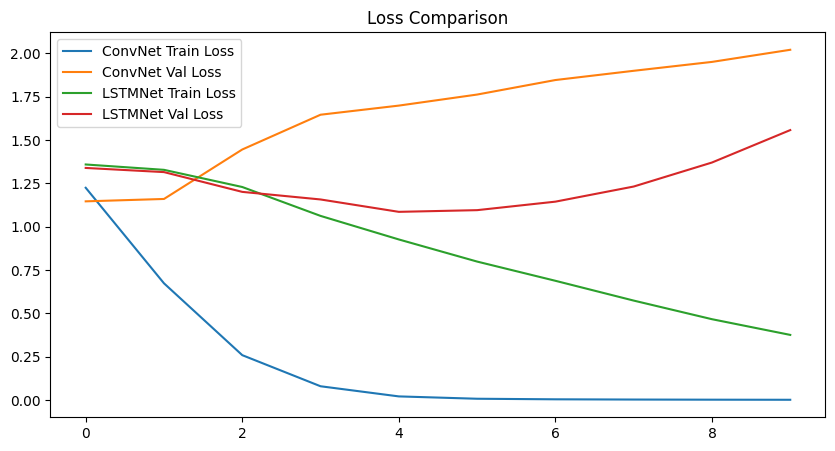

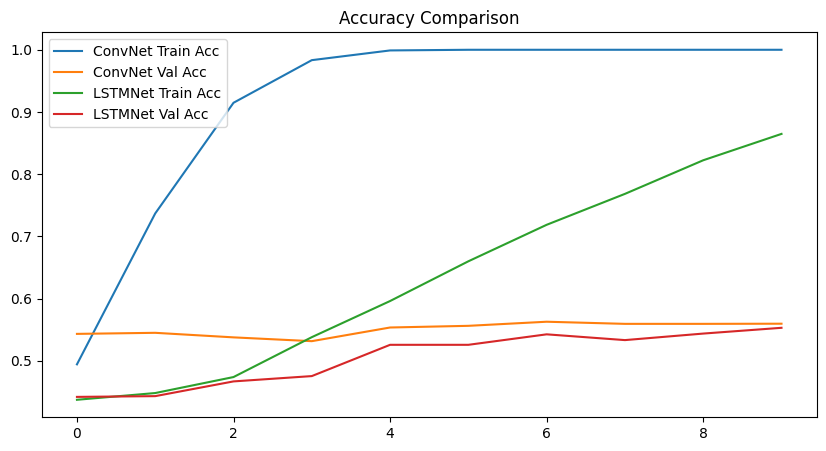

In [72]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_conv, label="ConvNet Train Loss")
plt.plot(val_loss_conv, label="ConvNet Val Loss")
plt.plot(train_loss_lstm, label="LSTMNet Train Loss")
plt.plot(val_loss_lstm, label="LSTMNet Val Loss")
plt.legend()
plt.title("Loss Comparison")
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_conv, label="ConvNet Train Acc")
plt.plot(val_acc_conv, label="ConvNet Val Acc")
plt.plot(train_acc_lstm, label="LSTMNet Train Acc")
plt.plot(val_acc_lstm, label="LSTMNet Val Acc")
plt.legend()
plt.title("Accuracy Comparison")
plt.show()


## Выводы

1. **Переобучение ConvNet**:
   - ConvNet демонстрирует высокую обучающую точность (100%), но ошибка на валидации растет, что указывает на переобучение.
   - Решения: добавить Dropout, увеличить регуляризацию (weight decay), использовать Early Stopping, или обогатить данные с помощью data augmentation.

2. **Медленная сходимость LSTMNet**:
   - LSTMNet обучается медленно, особенно в начальных эпохах, и показывает более низкую точность, чем ConvNet.
   - Решения: использовать двунаправленный LSTM, увеличить hidden_dim, попробовать GRU, а также оптимизировать гиперпараметры.

3. **Улучшение качества данных**:
   - Использование предобученных эмбеддингов (например, GloVe или Word2Vec) и увеличение длины токенов (max_len) может улучшить результаты обеих моделей.

4. **Общее сравнение**:
   - ConvNet быстрее обучается и достигает лучших результатов, но переобучается.
   - LSTMNet стабильнее, но требует больше времени и точной настройки гиперпараметров для достижения сравнимой точности.


# Почему batch_size = 32

1. **Баланс стабильности и производительности**:
   - Обеспечивает точное обновление весов и устойчивое обучение.
   - Эффективно использует вычислительные ресурсы (GPU).

2. **Обобщающая способность**:
   - Малый размер batch_size помогает избежать переобучения.
   - Позволяет модели лучше находить глобальные минимумы.